In [1]:
%matplotlib inline
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
import util

In [3]:
path = "DATA/IR VIS HAK/"

imgs_rgb, imgs_ir = util.loadDataset(path, "SAVE_2_visible_noBlack_frames", "SAVE_2_IR0_noBlack_frames")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 80, kernel_size=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(80, 100, kernel_size=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(200, 100),
            nn.ReLU(True),
            nn.Linear(100, 50), # add for model3
            nn.ReLU(True),     # add for model3
            nn.Linear(50, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[4].weight.data.zero_()
        self.fc_loc[4].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
    
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 200)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x, grid
    
    def forward(self, x):
        # transform the input
        x = self.stn(x)

        return x #F.log_softmax(x, dim=1)

model = Net()
model.load_state_dict(torch.load("modelAffine_v4.pt"))
model.eval()

Net(
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU(inplace=True)
    (15): Conv2d(80, 100, kernel_size=(3, 3), stride=(1, 1))
    (16): MaxPool2d(kernel_size=2, stride=2, pa

In [5]:
imgs_rgb.shape
imgs_ir.shape

(12633, 240, 320)

In [6]:
beg = 6400
end = 7700
imRGB = util.parseImages(imgs_rgb, end)
imRGB = imRGB[beg:end, ...]
imIR = util.parseImages(imgs_ir, end)
imIR = imIR[beg:end, ...]
imIR.shape

torch.Size([1300, 1, 240, 320])

In [7]:
def gradient_loss(s, penalty='l2'):
    dy = torch.abs(s[:, :, 1:, :] - s[:, :, :-1, :]) 
    dx = torch.abs(s[:, :, :, 1:] - s[:, :, :, :-1]) 

    if(penalty == 'l2'):
        dy = dy * dy
        dx = dx * dx

    d = torch.mean(dx) + torch.mean(dy)
    return d / 2.0

def gradient_magn_loss(fixedInput, warp):
    dy = torch.abs(fixedInput[:, :, 1:, 1:] - fixedInput[:, :, :-1, 1:]) 
    dx = torch.abs(fixedInput[:, :, 1:, 1:] - fixedInput[:, :, 1:, :-1]) 

    dy2 = torch.abs(warp[:, :, 1:, 1:] - warp[:, :, :-1, 1:]) 
    dx2 = torch.abs(warp[:, :, 1:, 1:] - warp[:, :, 1:, :-1])
        
    normV1 = torch.sqrt(dx*dx + dy*dy)
    normV2 = torch.sqrt(dx2*dx2 + dy2*dy2)
    
    #a = torch.zeros(normV1.shape)
    #update = normV1[normV1 > 0.04] and normV2[normV2 > 0.04]
    #a[update] = 1 - torch.abs(((dx/normV1)*(dx2/normV2) + (dy/normV1)*(dy2/normV2)))[update]  
    
    d = torch.mean(torch.abs(normV1 - normV2) + a*((normV1 + normV2)/2)) #+ a*torch.abs(normV1 - normV2)
    return d

In [8]:
mini_batch_size = 100
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(e, fixed_input, moving_input, mini_batch_size):
    model.train()
    sum_loss = 0
    criterion = nn.MSELoss()
    for b in range(0, fixed_input.size(0), mini_batch_size):
        
        optimizer.zero_grad()
        warp, flow = model(moving_input.narrow(0, b, mini_batch_size))
        
        recon_loss = criterion(warp, fixed_input.narrow(0, b, mini_batch_size))
        #recon_loss = F.nll_loss(warp, fixed_input.narrow(0, b, mini_batch_size))
        grad_loss = gradient_loss(flow)
        loss = recon_loss #+ 0.05 * grad_loss # 0.05 for model1 and model2
        sum_loss = sum_loss + loss.item()
        
        loss.backward()
        optimizer.step()

    print(e, sum_loss, loss, recon_loss)#grad_loss)

In [23]:
# train the data
for epoch in range(1, 31):
    train(epoch, imRGB, imIR, mini_batch_size)

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
warp, flow = model(imIR[None, 1351])
#print(warp[0,0])

plt.figure(figsize=(12,12))
plt.subplot(241)
warp = warp[0, ...].detach().numpy()
warp = warp[0, ...]

flow = flow[0, ...].detach().numpy()
flowx = flow[..., 0]
flowy = flow[..., 1]
plt.imshow(warp, cmap='gray')

plt.subplot(242)
plt.imshow(imRGB[1351, 0, ...].numpy(), cmap='gray')

plt.subplot(243)
plt.imshow(imIR[1351, 0, ...].numpy(), cmap='gray')

plt.subplot(244)
plt.imshow(imIR[1351, 0, ...].numpy() - imRGB[1351, 0, ...].numpy(), cmap='gray')

plt.subplot(245)
plt.imshow(-imRGB[1351, 0, ...].numpy() + warp, cmap='gray')

plt.subplot(246)
plt.imshow(flowx, cmap='gray')

plt.subplot(247)
plt.imshow(flowy, cmap='gray')


print(((warp - imIR[1351, 0, ...].numpy())**2).sum())
print(((warp - imRGB[1351, 0, ...].numpy())**2).sum())
print(((imIR[1351, 0, ...].numpy() - imRGB[1351, 0, ...].numpy())**2).sum())

In [ ]:
torch.save(model.state_dict(), "modelAffine_v9.pt")

C:\Users\lucaw\Anaconda3\lib\site-packages\torch\nn\functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\lucaw\Anaconda3\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


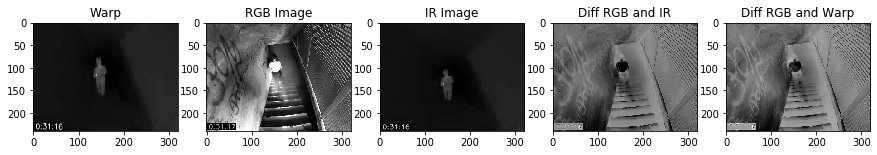

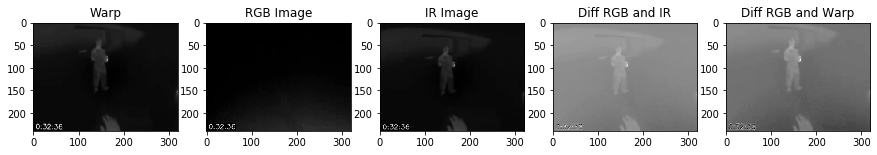

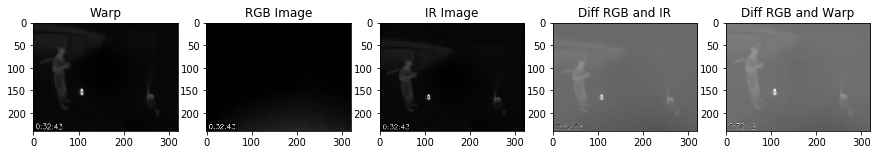

In [9]:
util.printResult(*util.getImagesById(imRGB, imIR, 251, model))
util.printResult(*util.getImagesById(imRGB, imIR, 1151, model))
util.printResult(*util.getImagesById(imRGB, imIR, 1230, model))

C:\Users\lucaw\Documents\EPFL\BachelorProject\util.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 15))


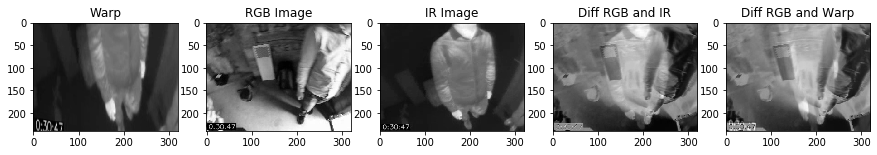

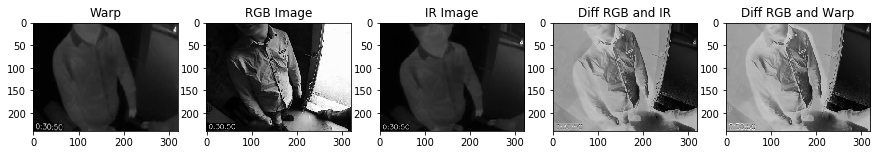

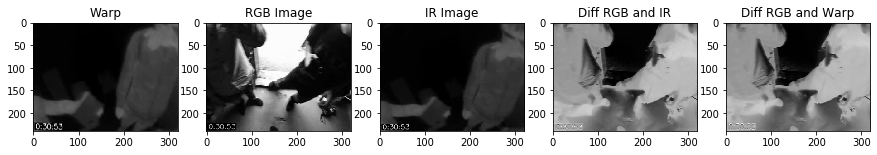

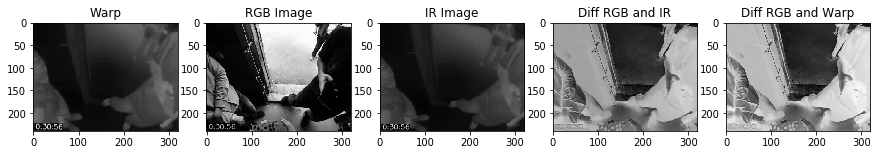

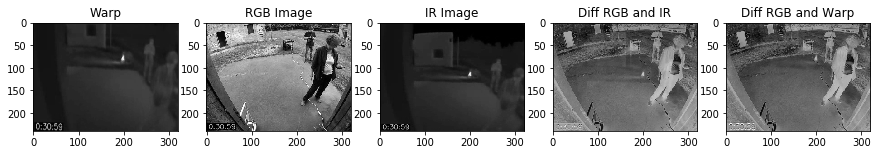

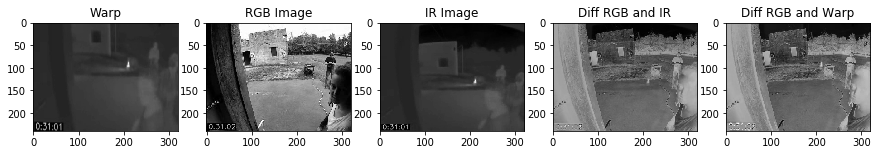

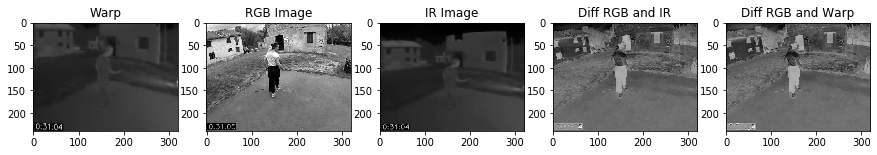

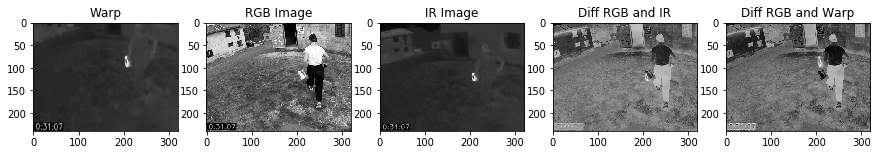

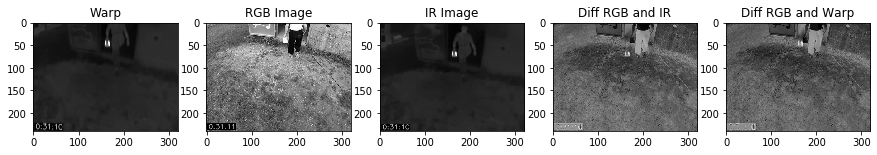

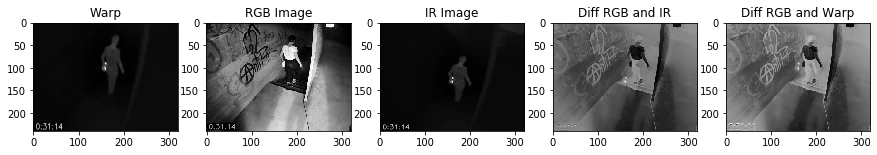

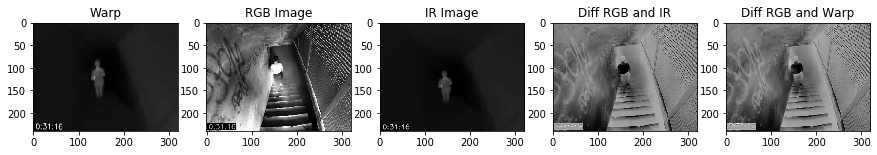

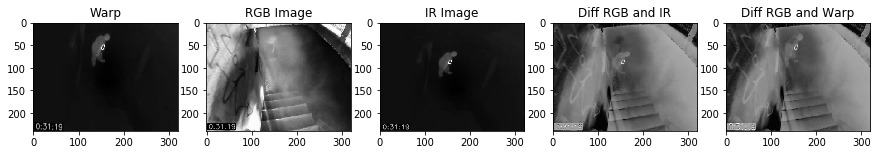

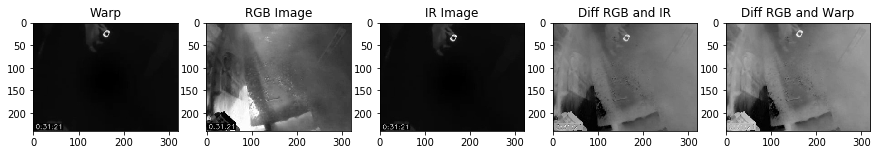

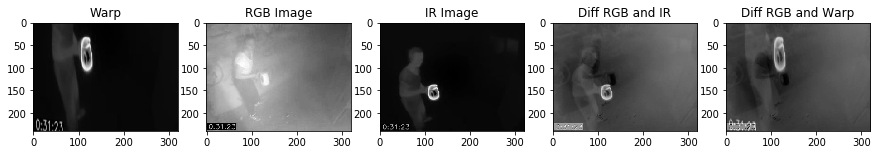

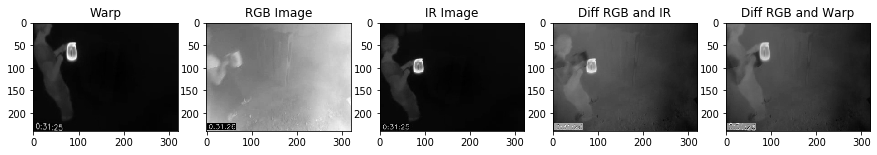

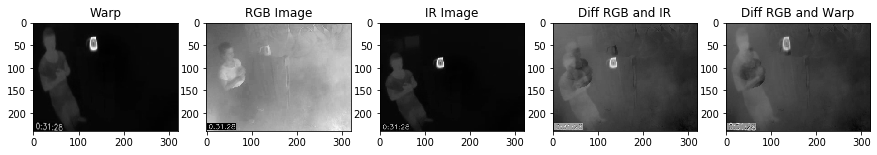

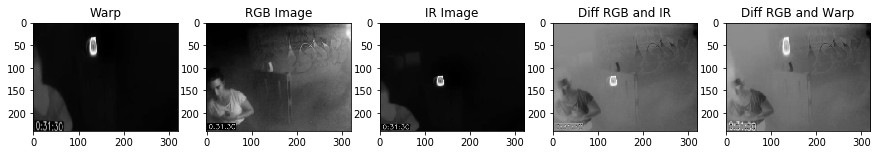

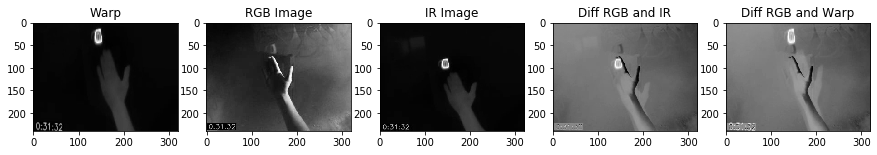

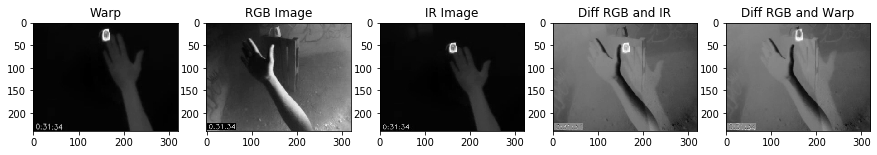

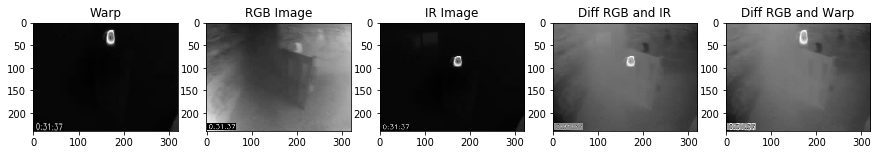

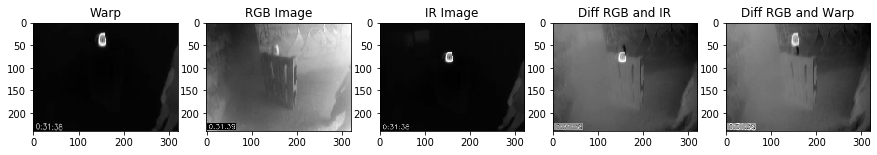

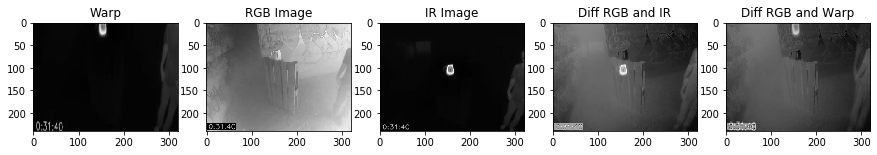

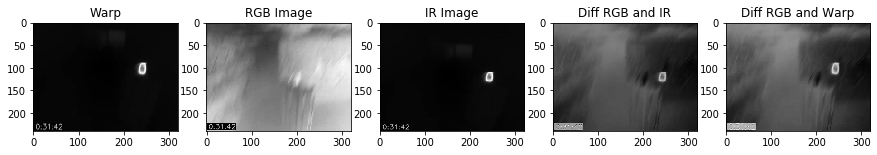

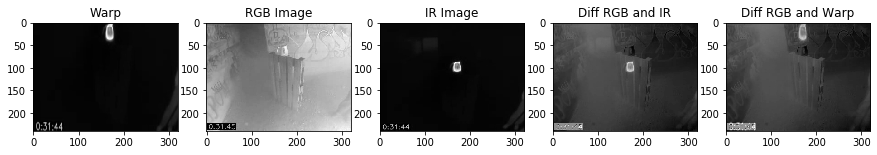

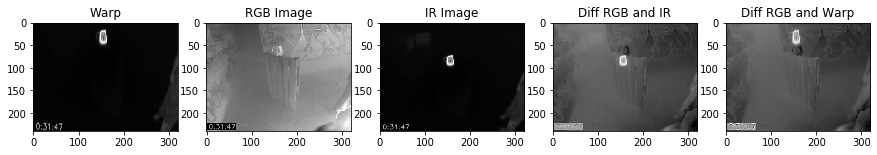

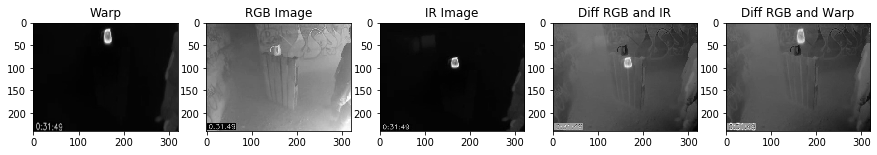

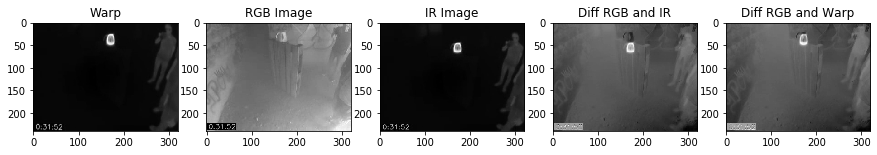

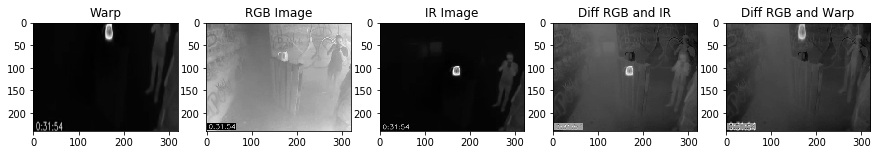

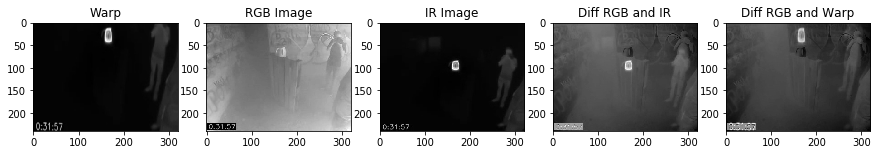

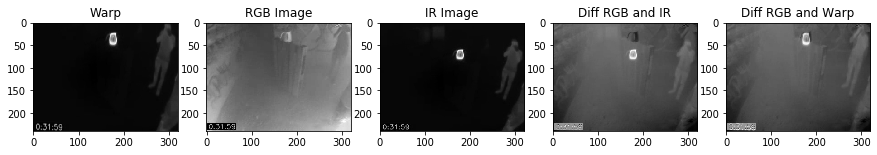

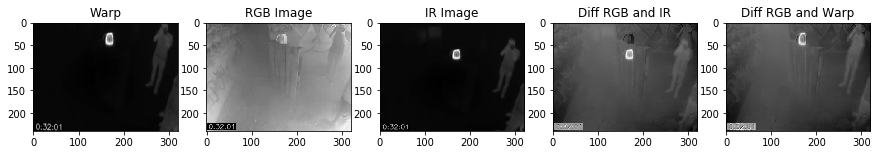

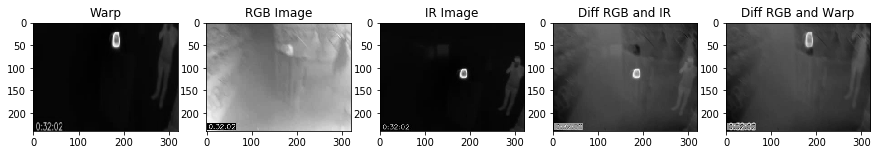

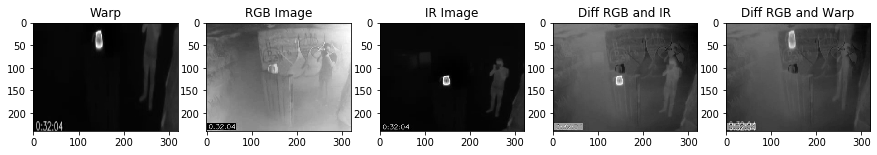

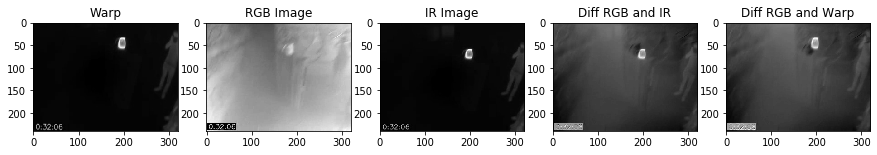

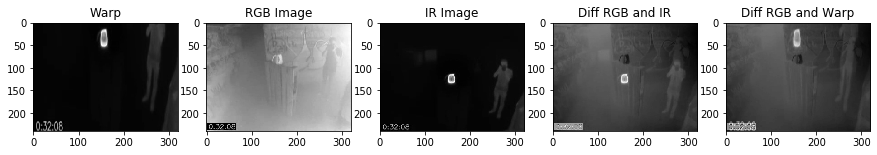

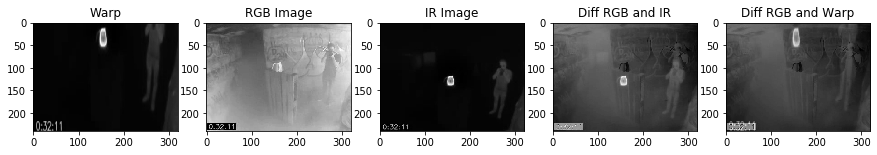

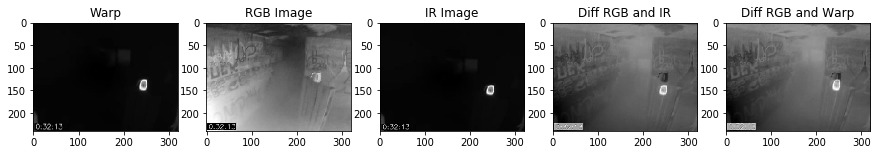

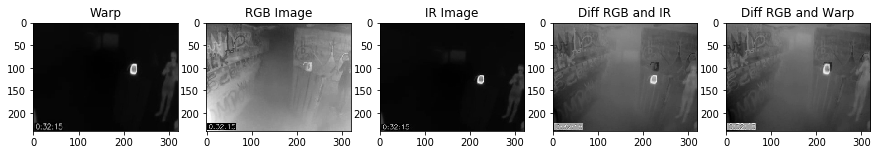

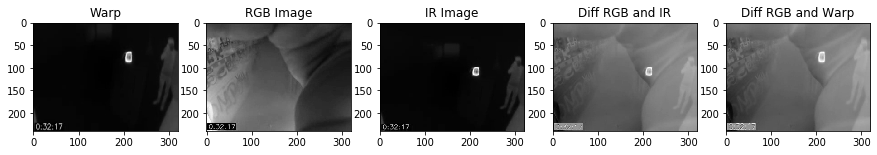

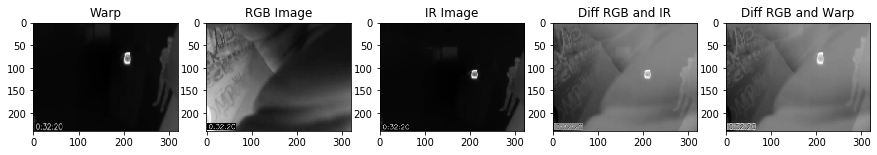

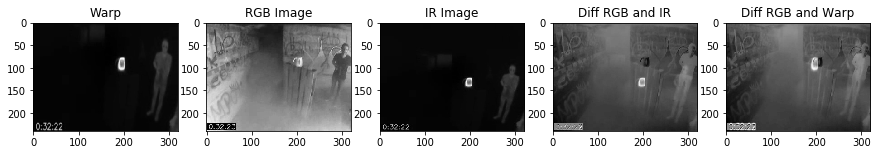

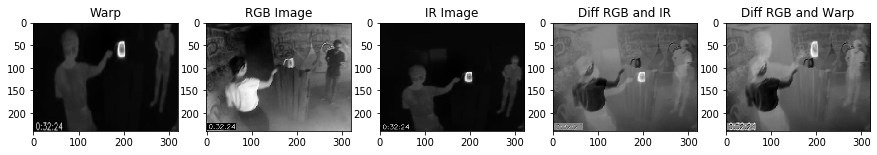

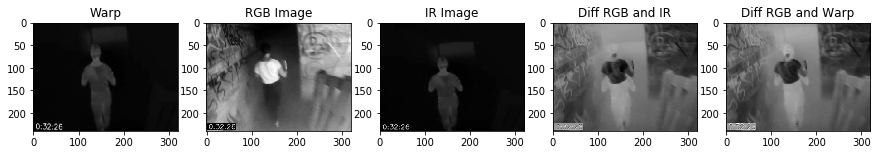

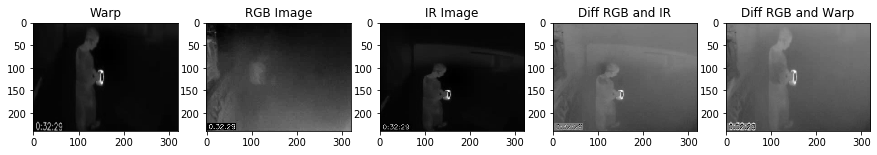

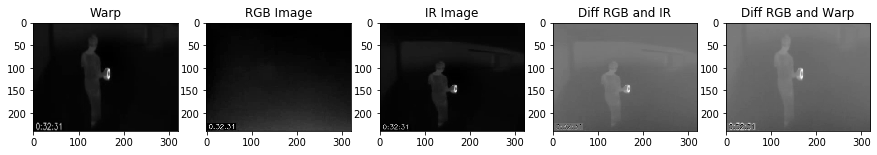

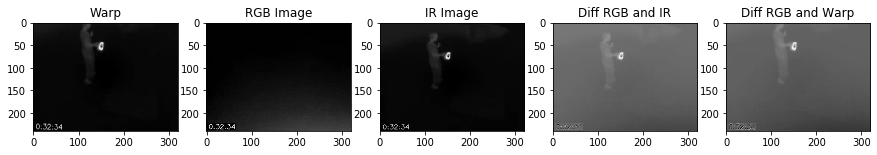

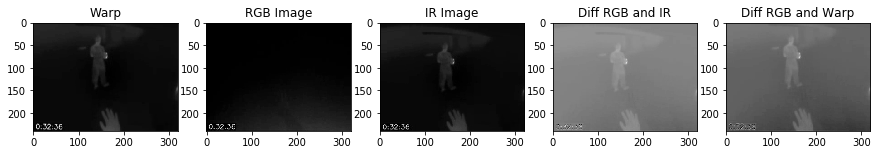

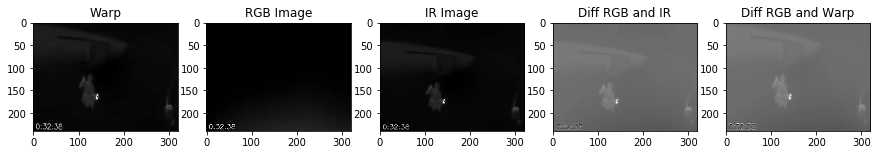

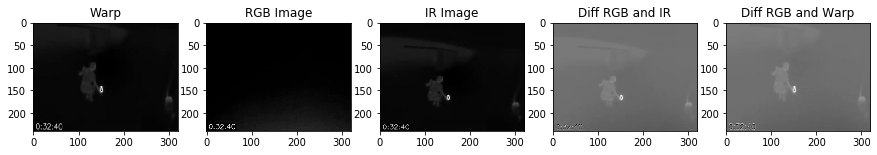

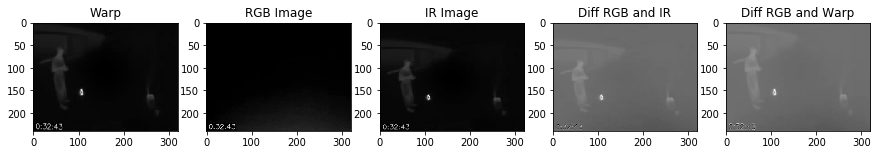

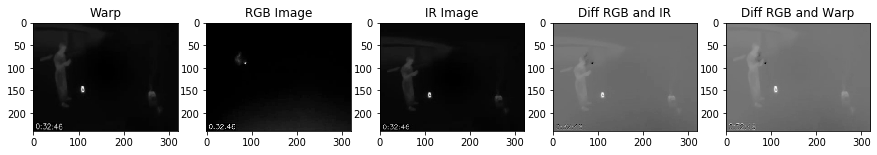

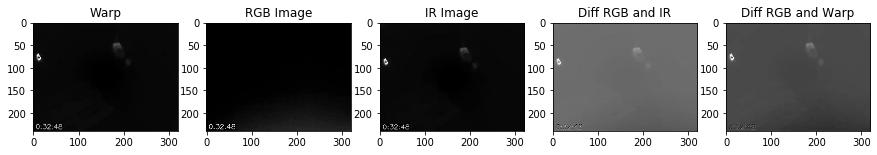

In [10]:
for i in range(0, 1300, 25):
    util.printResult(*util.getImagesById(imRGB, imIR, i, model))